In [1]:
# imports
import sys
import os
import mat73
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

sys.path.append( '../FIA' )
sys.path.append( '../ML' )
from FIA import *
from ML4com import *

# TensorFlow and tf.keras
import tensorflow as tf
import keras
import keras_tuner
from keras import layers, activations

In [2]:
def parse_folder(path):
    return os.listdir(path)


def mat_to_tsv(folder, file):
    """
    path: path to mat file
    saves mat files as tsv in the same folder
    """
    mat = mat73.loadmat(f"{folder}/{file}")
    for k, v in mat.items():
        if not os.path.isfile(f"{folder}/{k}.tsv"):
            df = pd.DataFrame(v)
            df.to_csv(f"{folder}/{k}.tsv", sep="\t", index=False)

In [3]:
for file in parse_folder("../../data/comm8_0"):
    if file.endswith(".mat"):
        mat_to_tsv("../../data/comm8_0", file)

In [4]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")

In [5]:
def join_df_metNames(df):
    cols = ["metNames"] + [f"MS{i+1}" for i in range(len(df.columns) - 6)]
    comb = pd.DataFrame(columns=cols)
    for pid in df["peakID"].unique():
        comb_met_name = ""
        for met_name in df.loc[df["peakID"] == pid]["MetName"]:
            comb_met_name += met_name + "\n"
        comb.loc[len(comb.index)] = [comb_met_name[:-2]] + list(df.loc[df["peakID"] == pid].iloc[0, 6:])
    comb = comb.set_index('metNames')
    return comb

In [6]:
def standard_normalization(df, axis=1):
    return df.apply(lambda line: [(x - np.mean(line)) / np.var(line) for x in line], result_type="expand", axis=axis)

In [7]:
met_raw_comb = pd.concat( [standard_normalization( join_df_metNames(met_raw_pos) ), standard_normalization( join_df_metNames(met_raw_neg) )] )

In [66]:
# Define data
X = met_raw_comb.transpose()
ys = comm8

## Model

In [78]:
def build_model(hyperparameters):
    model = keras.Sequential(name="MS_community_classifier")
    
    model.add(keras.layers.Dropout(hyperparameters.Float("dropout_in", min_value=0.0, max_value=0.99, sampling="linear"),
                                   noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())
    
    # Middle layers
    for i in range(hyperparameters.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hyperparameters.Int(f"units_{i}", min_value=32, max_value=256, step=64),
                activation=hyperparameters.Choice(f"activation_{i}", ["relu", "tanh"]),
            )
        )
        if hyperparameters.Boolean(f"dropout_{i}"):
            model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))
        model.add(keras.layers.BatchNormalization())

    model.add(layers.Dense(8,  activation=activations.sigmoid))     # Interpretation layer
    
    loss_function = keras.losses.CategoricalCrossentropy()

    learning_rate = hyperparameters.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    auc = keras.metrics.AUC(num_thresholds=200, curve="ROC", summation_method="interpolation")

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', auc])
    return model

### Hyperparameter optimization

In [79]:
from sklearn.model_selection import train_test_split
training_data, test_data, training_labels, test_labels = train_test_split(X, ys, test_size=0.2)# .iloc[:,0], test_size=0.2)

In [52]:
# Set tuner parameters
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    factor=5,
    max_epochs=200,
    directory='../../runs/NN/hyperband_optimization_2',
    project_name='classifier')

tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_in (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [54]:
tuner.search(training_data, training_labels,
             validation_data = (test_data, test_labels))

Trial 689 Complete [00h 00m 16s]
accuracy: 1.0

Best accuracy So Far: 1.0
Total elapsed time: 00h 58m 55s


In [55]:
tuner.results_summary(num_trials = 20)

Results summary
Results in ../../runs/NN/hyperband_optimization\classifier
Showing 20 best trials
Objective(name="accuracy", direction="max")

Trial 0023 summary
Hyperparameters:
dropout_in: True
num_layers: 2
units_0: 160
activation_0: relu
dropout_0: False
lr: 0.003937419409571616
units_1: 32
activation_1: relu
dropout_1: False
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 7
tuner/round: 0
Score: 1.0

Trial 0072 summary
Hyperparameters:
dropout_in: True
num_layers: 1
units_0: 96
activation_0: tanh
dropout_0: False
lr: 0.00118163725993479
units_1: 32
activation_1: relu
dropout_1: False
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 7
tuner/round: 0
Score: 1.0

Trial 0144 summary
Hyperparameters:
dropout_in: True
num_layers: 2
units_0: 160
activation_0: relu
dropout_0: False
lr: 0.003937419409571616
units_1: 32
activation_1: relu
dropout_1: False
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 7
tuner/round: 1
tuner/trial_id: 0023
Score: 1.0

Trial 0145 summary
Hyp

In [58]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
hp = keras_tuner.HyperParameters()
hp.Fixed("dropout", True)
hp.Fixed("num_layers", 1)
hp.Fixed("units_1", 64)
hp.Fixed("activation", "relu")
hp.Fixed("lr", 1e-3)

In [59]:
choice_hps = tuner.get_best_hyperparameters(num_trials = 2)[1]
model = build_model(choice_hps)

In [74]:
from sklearn.model_selection import KFold, StratifiedKFold
cv = 5
kf = StratifiedKFold(n_splits = cv, shuffle=True)

In [75]:
confusion_matrices = []
accuracies = []

for y in tqdm(ys.columns):
	y = ys[y]
	conf_mats = []
	acc = []
	for train_index, val_index in kf.split(X, y):
		model = build_model(choice_hps)
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)	# Model will stop when no improvment is reached after 1000 epochs
		history = model.fit(training_data, training_labels, epochs=10000, callbacks=[callback], verbose=0)

		val_loss, val_acc = model.evaluate(validation_data,  validation_labels, verbose="auto")
		acc.append(val_acc)
		prediction = model.predict(validation_data)
		prediction = [0.0 if pred[0] < 0.5 else 1.0 for pred in prediction]
		conf_mats.append(confusion_matrix(validation_labels,  prediction))
	
	accuracies.append(acc)
	confusion_matrices.append(np.sum(conf_mats, axis=0))

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▎        | 1/8 [00:31<03:42, 31.74s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2/8 [01:02<03:06, 31.12s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [01:35<02:40, 32.11s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [02:09<02:11, 32.85s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [02:38<01:34, 31.46s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6/8 [03:09<01:02, 31.40s/it]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 7/8 [03:40<00:31, 31.18s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [04:05<00:00, 30.64s/it]


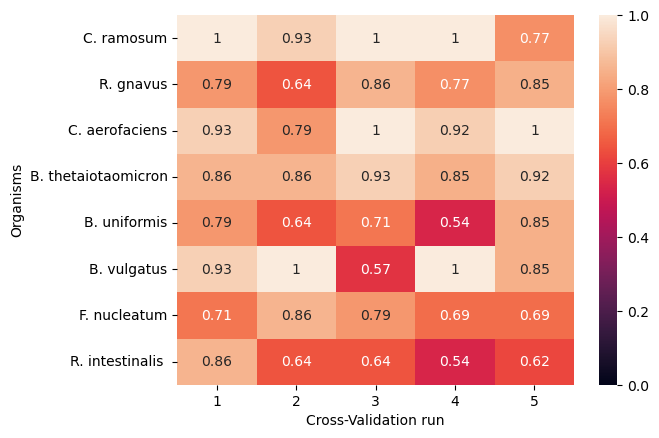

In [76]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=range(1,cv+1), index=strains["0"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
ax = sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)

In [77]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=np.mean(accuracies, axis=1), confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="class_annot_test_1.png")